<a href="https://colab.research.google.com/github/linhvien/Forecasting-sale-of-Philips-air-fryers/blob/main/Forecasting_models_of_Philips_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving data thesis.xlsx to data thesis.xlsx


# IMPORT LIBRARY

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import itertools
import re
import sklearn

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, StandardScaler

!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection

sns.set_style('ticks')
plt.figure(figsize=(18,6))

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 1.5 MB 5.1 MB/s 
     |████████████████████████████████| 9.5 MB 27.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


<Figure size 1296x432 with 0 Axes>

In [3]:
data = pd.read_excel('data thesis.xlsx')
data = data.melt(id_vars=['Mega Market', 'Posting Period'], var_name='Year', value_name='Quantity')
print(data)

       Mega Market  Posting Period                Year  Quantity
0             APAC               1      2016  Quantity       NaN
1             APAC               2      2016  Quantity       NaN
2             APAC               3      2016  Quantity       NaN
3             APAC               4      2016  Quantity       NaN
4             APAC               5      2016  Quantity       NaN
..             ...             ...                 ...       ...
571  North America               8  2021  PxQ Quantity       NaN
572  North America               9  2021  PxQ Quantity       NaN
573  North America              10  2021  PxQ Quantity       NaN
574  North America              11  2021  PxQ Quantity       NaN
575  North America              12  2021  PxQ Quantity       NaN

[576 rows x 4 columns]


# CLEAN DATA

In [4]:
# CLEAN & EDIT DATA
data = pd.read_excel('data thesis.xlsx')
data = data.melt(id_vars=['Mega Market', 'Posting Period'], var_name='Year', value_name='Quantity') #

# CONVERT TO DATE
data['Year'] = data.apply(lambda x: x['Year'].split(' ')[0], axis=1).astype('int64')
data['Date'] = data.apply(lambda x: '{}-{}'.format(x['Posting Period'], x['Year']), axis=1)
data['Date'] = pd.to_datetime(data['Date'], format='%m-%Y').apply(lambda x: '{}-{}'.format(x.strftime('%m'), x.strftime('%Y')))
data['Date_RAW'] = data['Date'].apply(lambda x: dt.datetime.strptime(x, '%m-%Y'))
data = data.sort_values(['Mega Market', 'Date_RAW']).reset_index(drop=True)

# CHANGE MARKET/AGGREGATE
data.loc[(data['Mega Market'] != 'Europe'), 'Mega Market'] = 'Rest of the world'
data = data.dropna().groupby(['Mega Market', 'Date', 'Year', 'Date_RAW'], as_index=False)['Quantity'].sum()

data = data.sort_values(['Mega Market', 'Date_RAW']).reset_index(drop=True)

# EXTRACT EXTERNAL VARIABLES, INCL. DAY-OF-THE-WEEK, MONTH, QUARTER, YEAR
data['Month'] = data['Date_RAW'].apply(lambda x: x.strftime('%B'))
data['Quarter'] = data['Date_RAW'].apply(lambda x: 'Q' + str(x.quarter))
data


,Mega Market,Date,Year,Date_RAW,Quantity,Month,Quarter
0,Europe,07-2016,2016,2016-07-01,28129.0,July,Q3
1,Europe,08-2016,2016,2016-08-01,26711.0,August,Q3
2,Europe,09-2016,2016,2016-09-01,31517.0,September,Q3
3,Europe,10-2016,2016,2016-10-01,37503.0,October,Q4
4,Europe,11-2016,2016,2016-11-01,42356.0,November,Q4
...,...,...,...,...,...,...,...
115,Rest of the world,02-2021,2021,2021-02-01,151395.0,February,Q1
116,Rest of the world,03-2021,2021,2021-03-01,149084.0,March,Q1
117,Rest of the world,04-2021,2021,2021-04-01,116889.0,April,Q2
118,Rest of the world,05-2021,2021,2021-05-01,132223.0,May,Q2


#SUMMARY

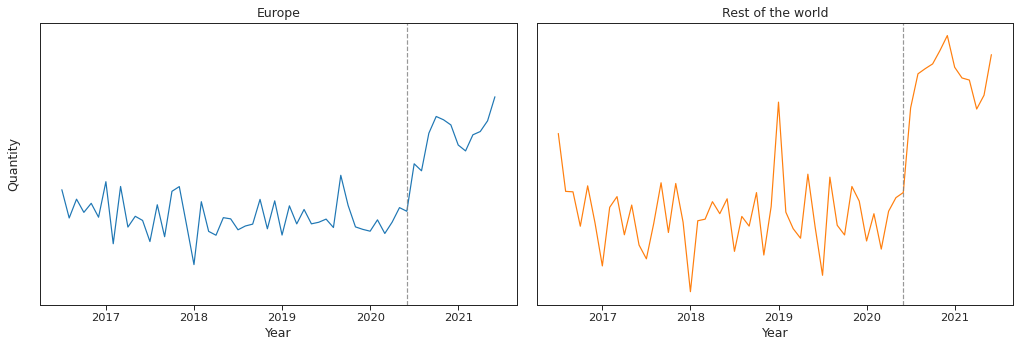

In [66]:
with sns.plotting_context('paper', font_scale=1.3):
  g = sns.FacetGrid(df, col='Mega Market', hue='Mega Market', col_wrap=2, size=5, aspect=1.5, despine=False)
  g = g.map(sns.lineplot, 'Date', 'Quantity')

  g.set(xticks=range(6, len(df['Date'].unique())+6, 12), xticklabels=df['Year'].unique()[1:])
  g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
  g.set(yticks=[], xlabel='Year')
  for ax in g.axes:
    ax.yaxis.labelpad=20
  for m, ax in zip('06-2020', g.axes.ravel()):
    ax.axvline(x='06-2020', color='tab:grey', linestyle='--', alpha=0.8)
  plt.show()

##Histogram

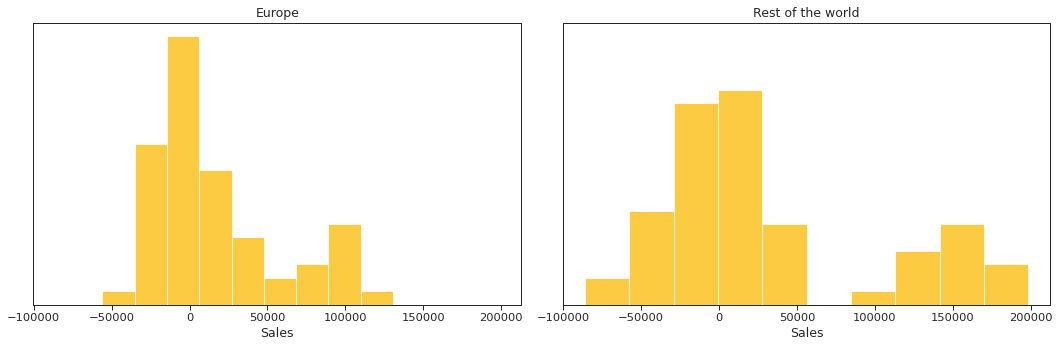

In [41]:
with sns.plotting_context('paper', font_scale=1.3):
  g = sns.FacetGrid(df, col='Mega Market', hue='Mega Market', col_wrap=2, size=5, aspect=1.5, despine=False)
  g = g.map_dataframe(sns.histplot,'Quantity', color='#fcba03')

  g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
  g.set(yticks=[], xlabel='Sales')
  for ax in g.axes:
    ax.yaxis.labelpad=20

##Stationary test

In [50]:
def KPSS(timeseries):
  kpsstest = kpss(timeseries, regression='c',nlags=3)
  kpss_output = pd.Series(kpsstest[0:3],index = ['Test Statistic','p-value','Lags Used'])
  for key, value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
  return kpss_output

def ADF(timeseries):
  adftest = adfuller(timeseries, regression='c',autolag='AIC')
  adf_output = pd.Series(adftest [0:4], index = ['Test Statistic','p-value','Lags Used','Number of Observations Used'])
  for key,value in adftest[4].items():
      adf_output['Critical Value (%s)'%key] = value
  return adf_output

list_market = ['Europe', 'Rest of the world']
for market in list_market:
  print('Stationary Tests for {}:'.format(market)+'\n Results of Dickey-Fuller test')

  df_kpss = pd.DataFrame({'Market': ['KPSS']})
  df_kpss = pd.concat([df_kpss, pd.DataFrame(KPSS(data[data['Mega Market'] == market]['Quantity'])).T.iloc[:, :-4]], axis=1)

  df_adf = pd.DataFrame({'Market': ['ADF']})
  df_adf = pd.concat([df_adf, pd.DataFrame(ADF(data[data['Mega Market'] == market]['Quantity'])).T.iloc[:, :-4]], axis=1)

  df_output = pd.concat([df_kpss, df_adf]).reset_index(drop=True)
  print(df_output)

Stationary Tests for Europe:
 Results of Dickey-Fuller test
  Market  Test Statistic   p-value  Lags Used
0   KPSS        0.683205  0.015072        3.0
1    ADF       -2.140208  0.228657        2.0
Stationary Tests for Rest of the world:
 Results of Dickey-Fuller test
  Market  Test Statistic   p-value  Lags Used
0   KPSS        0.511154  0.039154        3.0
1    ADF       -2.279199  0.178765        3.0


##ACF & PACF plots

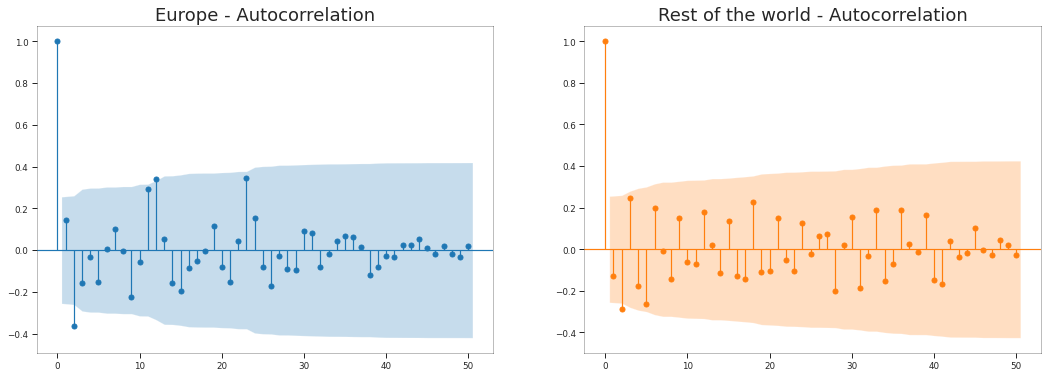

In [58]:
#Autocorrelation plots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,6))
list_args = {}
list_args['Europe'] = {'color': 'tab:blue', 'ax': ax1}
list_args['Rest of the world'] = {'color': 'tab:orange', 'ax': ax2}
for market in list_market:
  plot_acf(data[data['Mega Market'] == market]['Quantity'].diff(1)[1:], ax=list_args[market]['ax'], lags=50, title='{} - Autocorrelation'.format(market), color=list_args[market]['color'], vlines_kwargs={'colors': list_args[market]['color']})
  for coord in ['top', 'bottom', 'left', 'right']:
    list_args[market]['ax'].spines[coord].set_alpha(0.3)
  for item in list_args[market]['ax'].collections:
    if type(item)==PolyCollection:
        item.set_facecolor(list_args[market]['color'])

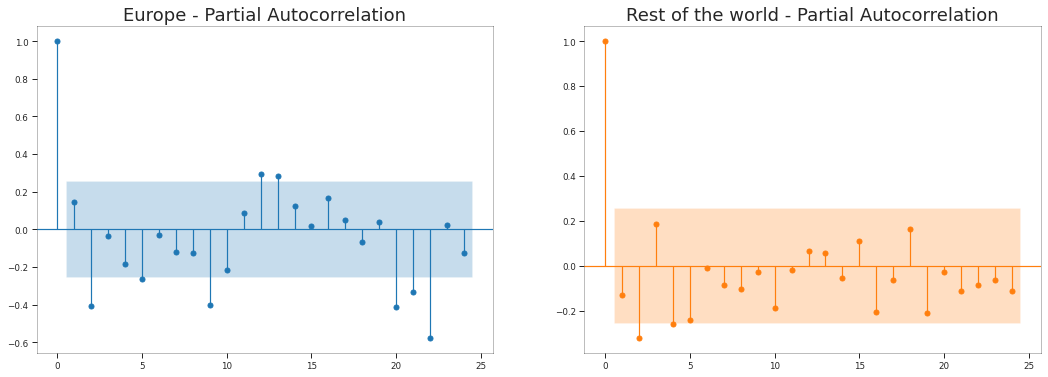

In [64]:
#Partial Autocorrelation plots
fig, (ax1,ax2)= plt.subplots(1,2,figsize=(18,6))
list_arg = {}
list_arg['Europe']={'color':'tab:blue','ax':ax1}
list_arg['Rest of the world']={'color':'tab:orange','ax':ax2}
for market in list_market:
  plot_pacf(data[data['Mega Market'] == market]['Quantity'].diff(1)[1:],ax=list_arg[market]['ax'], lags=24, title='{} - Partial Autocorrelation'.format(market), color=list_arg[market]['color'], vlines_kwargs={'colors': list_arg[market]['color']})
  for coord in ['top','bottom','left','right']:
    list_arg[market]['ax'].spines[coord].set_alpha(0.3)
  for item in list_arg[market]['ax'].collections:
    if type(item)==PolyCollection:
      item.set_facecolor(list_arg[market]['color'])


# CREATE GRAPH

In [7]:
### USER-DEFINED FUNCTIONS ###

# CREATE DF PLOT
def create_df_plot(model, list_input):
  dates = data.loc[data['Date_RAW'] >= '2020-07-01', 'Date_RAW'].unique()
  df_output = pd.DataFrame()
  for market in list(list_input):
    df_market = list_input[market]
    for i in range(len(df_market)):
      temp = pd.DataFrame({'Date_RAW': [dates[i]], 'Mega Market': [market]})
      temp[model] = df_market.iloc[i, 0]
      df_output = df_output.append(temp, ignore_index=True)
  return df_output

# CREATE DF PLOT RESIDUALS
def create_df_plot_resid(model, list_input):
  dates = data.loc[data['Date_RAW'] < '2020-07-01', 'Date_RAW'].unique()
  df_output = pd.DataFrame()
  for market in list(list_input):
    df_market = list_input[market]
    for i in range(len(df_market)):
      temp = pd.DataFrame({'Date_RAW': [dates[i]], 'Mega Market': [market]})
      temp[model] = df_market.iloc[i, 0]
      df_output = df_output.append(temp, ignore_index=True)
  return df_output

# CREATE GRAPH
def create_graph(df_input, start='2020-01-01', end='2021-12-01', nr_model=1):
  df_true = data[(data['Date_RAW'] >= start) & (data['Date_RAW'] < end)][['Mega Market', 'Date', 'Date_RAW', 'Quantity']].rename(columns={'Quantity': 'True'})

  # CREATE DF PLOT
  df_plot = df_true.merge(df_input, on=['Date_RAW', 'Mega Market'], how='left')

  # ALIGN FORECASTED LINE WITH TRUE LINE
  NAN_last = df_plot[df_plot.isna().any(axis=1)]['Date_RAW'].unique()[-1]
  df_plot.iloc[df_plot['Date_RAW'] == NAN_last, -1] = df_plot[df_plot['Date_RAW'] == NAN_last].loc[:, 'True']

  # CREATE GRAPH
  with sns.plotting_context('paper', font_scale=1.3):
    g = sns.FacetGrid(df_plot, col='Mega Market', col_wrap=2, size=5, aspect=1.5, despine=False)
    g = g.map(sns.lineplot, 'Date', 'True', color='tab:blue', label='True')
    g = g.map(sns.lineplot, 'Date', df_plot.columns[-1], color='tab:red', label=df_plot.columns[-1])

    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    g.set(xticks=range(0, len(df_plot['Date'].unique()), 3), xticklabels=df_plot['Date'].unique()[::3])
    g.set(yticks=[], xlabel='Date', ylabel='Quantity')
    for ax in g.axes:
      ax.yaxis.labelpad=20
    for ax in g.axes.ravel():
      ax.legend()

  for m, ax in zip('06-2020', g.axes.ravel()):
    ax.axvline(x='06-2020', color='tab:grey', linestyle='--', alpha=0.8)

  return g

# HOLT-WINTER Model

Europe - Holt-Winter models: 
                       ExponentialSmoothing Model Results                       
Dep. Variable:                 Quantity   No. Observations:                   48
Model:             ExponentialSmoothing   SSE                    22851904836.148
Optimized:                         True   AIC                            991.093
Trend:                   Multiplicative   BIC                           1021.032
Seasonal:                Multiplicative   AICC                          1014.679
Seasonal Periods:                    12   Date:                 Mon, 09 Aug 2021
Box-Cox:                          False   Time:                         07:35:16
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0050000                alpha                 

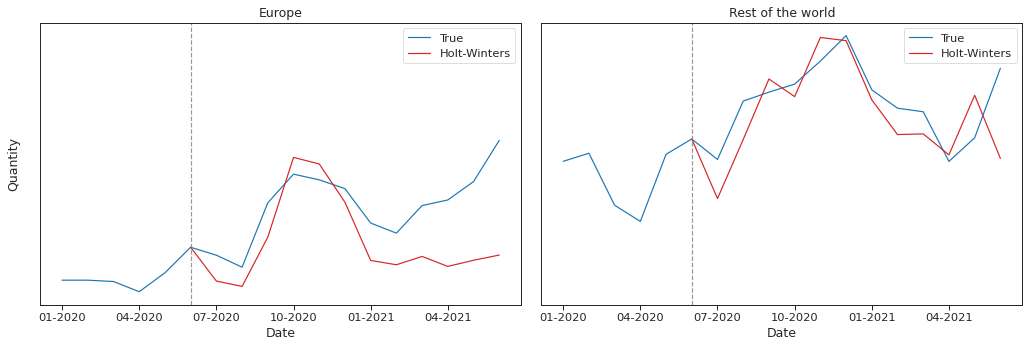

In [8]:

# INITIALIZE/SELECT MARKET
df = data.copy()
list_markets = ['Europe', 'Rest of the world']

# PERFORM FORECASTING ANALYSIS
list_preds_HW = {}
for market in list_markets:
  random_seed = 1234
  df_market = df[df['Mega Market'] == market]

  # SPLIT INTO TRAINING & TEST SET
  X_train = df_market[df_market['Date_RAW'] < '2020-07-01']['Quantity'].reset_index(drop=True)
  X_test = df_market[df_market['Date_RAW'] >= '2020-07-01']['Quantity'].reset_index(drop=True)

  # HOLT-WINTERS MODEL MULTI-STEP AHEAD
  HW = ExponentialSmoothing(X_train, trend='mul', seasonal='mul', seasonal_periods=12).fit()
  print('{} - Holt-Winter models: '.format(market))
  print(HW.summary())
  HW_preds = HW.forecast(len(X_test))
  

  # STORE RESULTS HOLT-WINTERS
  df_results = pd.DataFrame({'Holt-Winters_preds': HW_preds})
  list_preds_HW[market] = df_results

df_HW = create_df_plot('Holt-Winters', list_preds_HW)
print(df_HW)
create_graph(df_HW)

# ARIMA Model

Europe - ARIMA models: 
        Order          AIC  In-sample RMSE  In-sample MAPE
0   (0, 1, 0)  1072.807953    14760.666223        0.304470
1   (0, 1, 1)  1072.868706    15078.971614        0.317881
2   (0, 1, 2)  1067.268911    13592.863130        0.288667
3   (0, 1, 3)  1061.810164    12865.445130        0.295823
4   (0, 1, 4)  1069.662605    13829.533897        0.319909
5   (1, 1, 0)  1074.077418    14923.570442        0.308599
6   (1, 1, 1)  1073.895950    14799.331827        0.309491
7   (1, 1, 2)  1063.061730    12626.068554        0.281654
8   (1, 1, 3)  1062.077150    12859.569606        0.291811
9   (1, 1, 4)  1063.020133    13943.690034        0.330683
10  (2, 1, 0)  1068.034207    14000.896165        0.297445
11  (2, 1, 1)  1065.295238    13453.714256        0.321091
12  (2, 1, 2)  1066.774634    13202.744811        0.284157
13  (2, 1, 3)  1062.511373    13338.856301        0.311489
14  (2, 1, 4)  1065.338902    12755.281853        0.287344
15  (3, 1, 0)  1069.834139    14

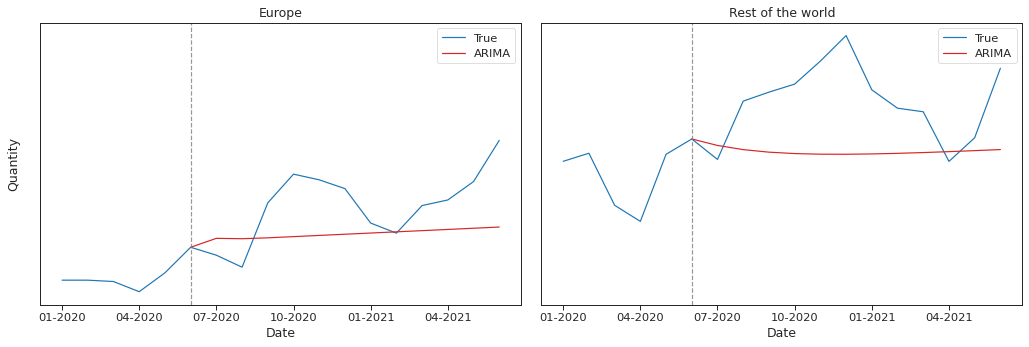

In [9]:
### ARIMA MODEL ###

def rmse(resid):
  return np.sqrt(np.square(resid)).mean()

def mape(resid, true):
  return np.mean(np.abs(resid)/true)

# INITIALIZE/SELECT MARKET
df = data.copy()
list_markets = ['Europe', 'Rest of the world']

list_params = {'p': list(range(0,5)), 'q': list(range(0,5))}
list_ARIMA = {}
list_resid_ARIMA = {}
list_best_model = {}
for market in list_markets:
  random_seed = 1234
  df_market = df[df['Mega Market'] == market]

  # SPLIT INTO TRAINING & TEST SET
  X_train = df_market[df_market['Date_RAW'] < '2020-07-01']['Quantity'].reset_index(drop=True)
  X_test = df_market[df_market['Date_RAW'] >= '2020-07-01']['Quantity'].reset_index(drop=True)

  df_ARIMA = pd.DataFrame()
  for order in [(p,1,q) for p, q in itertools.product(list_params['p'], list_params['q'])]:
    ARIMA = sm.tsa.SARIMAX(X_train, order=order, trend='c', random_seed=random_seed).fit()
    
    temp = pd.DataFrame({'Order': [order], 'AIC': [ARIMA.aic], 'In-sample RMSE': [rmse(ARIMA.resid)], 'In-sample MAPE': [mape(ARIMA.resid, X_train)]})
    df_ARIMA = df_ARIMA.append(temp, ignore_index=True)

  list_ARIMA[market] = df_ARIMA
  print('{} - ARIMA models: '.format(market))
  print(df_ARIMA)
  best_model = df_ARIMA.sort_values('AIC').iloc[0, :]
  list_best_model[market] = best_model
  print('\n Best Model: {}, AIC={} \n'.format(best_model['Order'], best_model['AIC']))

  # ARIMA MODEL MULTI-STEP AHEAD
  #ARIMA = auto_arima(X_train, max_p=3, max_q=3, d=1, seasonal=False, stepwise=False, random_state=random_seed).fit(X_train)
  ARIMA = sm.tsa.SARIMAX(X_train, order=list_best_model[market]['Order'], trend='c', random_seed=random_seed).fit()
  #ARIMA_preds = ARIMA.predict(n_periods=len(X_test))
  ARIMA_preds = ARIMA.forecast(steps=len(X_test))
  ARIMA_resid = pd.Series(ARIMA.resid)

  # STORE RESULTS ARIMA
  df_results = pd.DataFrame({'ARIMA_preds': ARIMA_preds})
  list_ARIMA[market] = df_results

  # STORE RESIDUALS OF ARIMA
  df_resid = pd.DataFrame({'ARIMA': ARIMA_resid})
  list_resid_ARIMA[market] = df_resid

df_ARIMA = create_df_plot('ARIMA', list_ARIMA)
df_ARIMA_resid = create_df_plot_resid('ARIMA_Resid', list_resid_ARIMA)

create_graph(df_ARIMA)
  

# SARIMA Model

Europe - SARIMA models: 
         Order Seasonal Order         AIC  In-sample RMSE  In-sample MAPE
0    (0, 1, 0)  (0, 1, 0, 12)  815.219430    17364.375748        0.383769
1    (0, 1, 0)  (0, 1, 1, 12)  809.325732    15219.786981        0.328222
2    (0, 1, 0)  (0, 1, 2, 12)  811.294121    15177.428581        0.326979
3    (0, 1, 0)  (1, 1, 0, 12)  810.738141    15431.604717        0.331464
4    (0, 1, 0)  (1, 1, 1, 12)  811.296084    15179.091526        0.326924
..         ...            ...         ...             ...             ...
139  (3, 1, 3)  (1, 1, 1, 12)  817.651551    16242.430982        0.379340
140  (3, 1, 3)  (1, 1, 2, 12)  812.005914    16038.204041        0.388849
141  (3, 1, 3)  (2, 1, 0, 12)  811.205626    16340.665585        0.393510
142  (3, 1, 3)  (2, 1, 1, 12)  816.059033    16255.735891        0.376433
143  (3, 1, 3)  (2, 1, 2, 12)  813.991522    16065.377363        0.389357

[144 rows x 5 columns]

 Best Model: (1, 1, 3) (0, 1, 1, 12)], AIC=802.7684526637044 


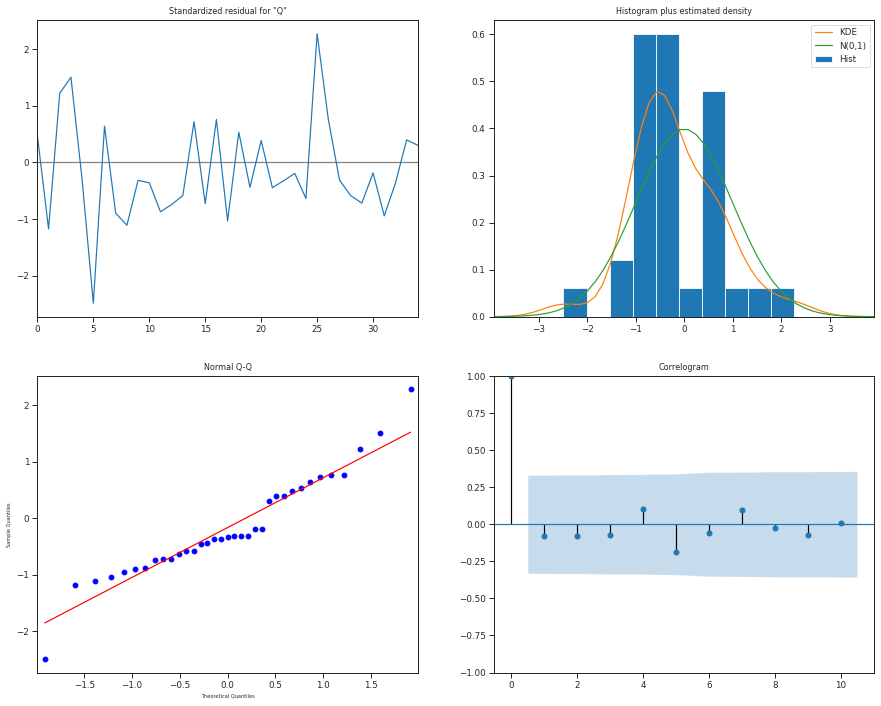

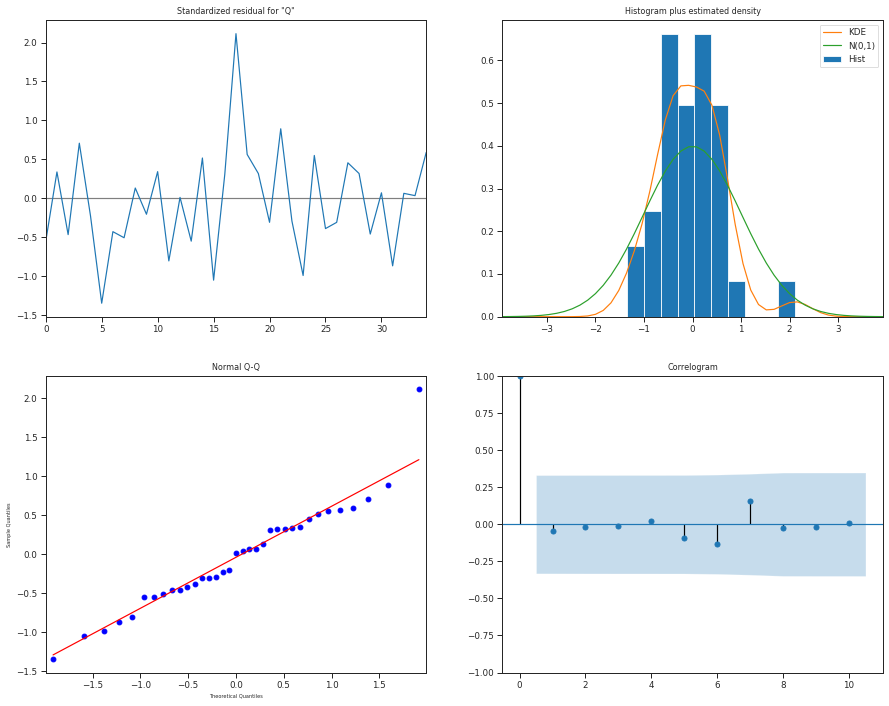

In [10]:
### SARIMA MODEL ###

def rmse(resid):
  return np.sqrt(np.square(resid)).mean()

def mape(resid, true):
  return np.mean(np.abs(resid)/true)

# INITIALIZE/SELECT MARKET
df = data.copy()
list_markets = ['Europe', 'Rest of the world']

list_params = {'p': list(range(0,4)), 'q': list(range(0,4)), 'P': list(range(0,3)), 'Q': list(range(0,3))}
list_SARIMA = {}
list_order = {'Europe': (0,1,3), 'Rest of the world': (1,1,1)}
list_best_model = {}
for market in list_markets:
  random_seed = 1234
  df_market = df[df['Mega Market'] == market]

  # SPLIT INTO TRAINING & TEST SET
  X_train = df_market[df_market['Date_RAW'] < '2020-07-01']['Quantity'].reset_index(drop=True)
  X_test = df_market[df_market['Date_RAW'] >= '2020-07-01']['Quantity'].reset_index(drop=True)

  df_SARIMA = pd.DataFrame()
  for order in [(p,1,q) for p, q in itertools.product(list_params['p'], list_params['q'])]:
    for seasonal_order in [(P,1,Q,12) for P,Q in itertools.product(list_params['P'], list_params['Q'])]:
      SARIMA = sm.tsa.SARIMAX(X_train, order=order, seasonal_order=seasonal_order, trend='c', random_seed=random_seed).fit() 
      temp = pd.DataFrame({'Order': [order], 'Seasonal Order': [seasonal_order], 'AIC': [SARIMA.aic], 'In-sample RMSE': [rmse(SARIMA.resid)], 'In-sample MAPE': [mape(SARIMA.resid, X_train)]})
      df_SARIMA = df_SARIMA.append(temp, ignore_index=True)

  list_SARIMA[market] = df_SARIMA
  print('{} - SARIMA models: '.format(market))
  print(df_SARIMA)
  best_model = df_SARIMA.sort_values('AIC').iloc[0, :]
  list_best_model[market] = best_model
  print('\n Best Model: {} {}], AIC={} \n'.format(best_model['Order'], best_model['Seasonal Order'], best_model['AIC']))
  bestmodel = sm.tsa.SARIMAX(X_train, order=(1, 1, 3), seasonal_order=(0, 1, 1, 12)).fit(dis=-1)
  print('{} - SARIMA output: '.format(market))
  print(bestmodel.summary())
  print ('{} - Diagnostic models: '.format(market))
  bestmodel.plot_diagnostics(figsize=(15,12))
  

     Date_RAW        Mega Market         SARIMA
0  2020-07-01             Europe   56531.988277
1  2020-08-01             Europe   56448.002007
2  2020-09-01             Europe   70900.729974
3  2020-10-01             Europe  102706.363964
4  2020-11-01             Europe  110643.475047
5  2020-12-01             Europe  101006.984914
6  2021-01-01             Europe   78877.296363
7  2021-02-01             Europe   78345.429600
8  2021-03-01             Europe   85711.062249
9  2021-04-01             Europe   84707.866582
10 2021-05-01             Europe   85163.214021
11 2021-06-01             Europe   94313.714298
12 2020-07-01  Rest of the world  123010.897432
13 2020-08-01  Rest of the world  149482.626787
14 2020-09-01  Rest of the world  171571.340538
15 2020-10-01  Rest of the world  159988.506075
16 2020-11-01  Rest of the world  188698.584489
17 2020-12-01  Rest of the world  191513.072298
18 2021-01-01  Rest of the world  163722.534095
19 2021-02-01  Rest of the world  169211

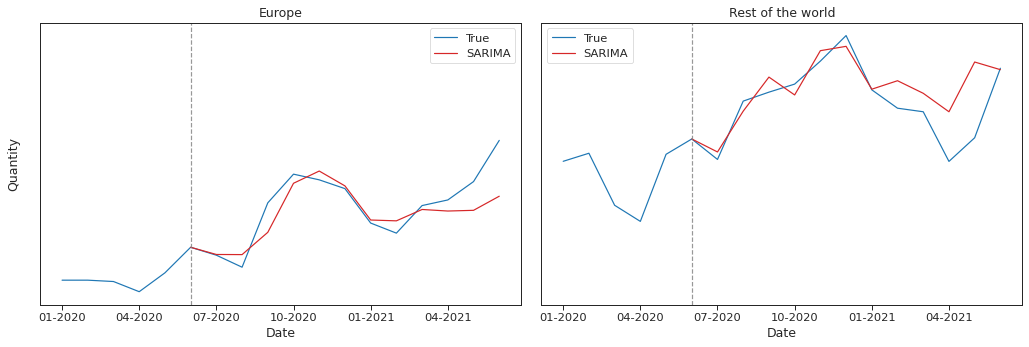

In [11]:
### SARIMA MODEL ###

# INITIALIZE/SELECT MARKET
df = data.copy()
list_markets = ['Europe', 'Rest of the world']

# PERFORM FORECASTING ANALYSIS
list_preds_SARIMA = {}
list_resid_SARIMA = {}
for market in list_markets:
  random_seed = 1234
  df_market = df[df['Mega Market'] == market]

  # SPLIT INTO TRAINING & TEST SET
  X_train = df_market[df_market['Date_RAW'] < '2020-07-01']['Quantity'].reset_index(drop=True)
  X_test = df_market[df_market['Date_RAW'] >= '2020-07-01']['Quantity'].reset_index(drop=True)

  # SARIMA MODEL MULTI-STEP AHEAD
  #SARIMA = auto_arima(X_train, max_p=3, max_q=3, d=1, D=1, max_Q=2, max_D=2, seasonal=True, m=12, stepwise=False, random_state=random_seed).fit(X_train)
  #SARIMA_preds = SARIMA.predict(n_periods=len(X_test))
  #SARIMA_resid = pd.Series(SARIMA.resid())
  SARIMA = sm.tsa.SARIMAX(X_train, order=list_best_model[market]['Order'], seasonal_order=list_best_model[market]['Seasonal Order'], trend='c', random_seed=random_seed).fit()
  SARIMA_preds = SARIMA.forecast(steps=len(X_test))
  SARIMA_resid = SARIMA.resid

  # STORE RESULTS ARIMA
  df_results = pd.DataFrame({'SARIMA_preds': SARIMA_preds})
  list_preds_SARIMA[market] = df_results

  # STORE RESIDUALS OF SARIMA
  df_resid = pd.DataFrame({'SARIMA': SARIMA_resid})
  list_resid_SARIMA[market] = df_resid

df_SARIMA = create_df_plot('SARIMA', list_preds_SARIMA)
df_SARIMA_resid = create_df_plot_resid('SARIMA_Resid', list_resid_SARIMA)
print(df_SARIMA)
create_graph(df_SARIMA)

# SVR Model

SVR(C=1, cache_size=1500, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
SVR(C=1, cache_size=1500, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
     Date_RAW        Mega Market            SVR
0  2020-07-01             Europe   28156.000014
1  2020-08-01             Europe   22269.995541
2  2020-09-01             Europe   43490.564194
3  2020-10-01             Europe   78888.604705
4  2020-11-01             Europe   83314.078285
5  2020-12-01             Europe   53923.076549
6  2021-01-01             Europe   37553.433488
7  2021-02-01             Europe   42099.175258
8  2021-03-01             Europe   50026.537295
9  2021-04-01             Europe   44181.464845
10 2021-05-01             Europe   34228.246681
11 2021-06-01             Europe   32103.975240
12 2020-07-01  Rest of the world  103331.541156
13 2020-08-01  Rest of the world  104318.314

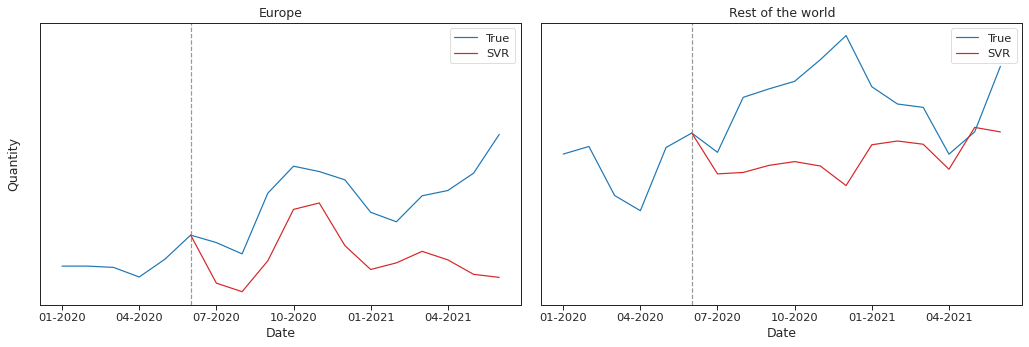

In [12]:
### SVR MODEL ###

# INITIALIZE/SELECT MARKET
df = data.copy()
list_markets = ['Europe', 'Rest of the world']

# FUNCTION TO CREATE LAGS USED FOR PERFORMING MODELS
def create_lag(data, lags=[]):
  output = pd.DataFrame({'value': data.values.ravel()})
  for i in lags:
    output['lag_{}'.format(i)] = data.shift(i)
  output = output.dropna()
  return output

# PERFORM FORECASTING ANALYSIS
list_preds_SVR = {}
for market in list_markets:
  random_seed = 1234
  df_market = df[df['Mega Market'] == market]

  Y_scaler = MinMaxScaler().fit(df_market['Quantity'].to_frame())
  df_market['Quantity'] = Y_scaler.transform(df_market['Quantity'].to_frame()).ravel()
  
  #############################
  ### FEATURE/LAG SELECTION ###
  #############################

  # ADD LAGGED VARIABLES AS PREDICTORS: PAST 24-MONTHS
  X = df_market[df_market['Date_RAW'] < '2020-07-01']['Quantity'].reset_index(drop=True)
  X = pd.DataFrame(X)
  lag_range = [i+1 for i in range(24)]
  X = create_lag(X.iloc[:, :1], lag_range)

  # SPLIT INTO TRAINING & TEST SET
  X_train = X.iloc[:, 1:]
  y_train = X.iloc[:, :1]

  # FEATURE SELECTION ON LAGGED REGRESSORS USING RF BASED ON PERMUTATION PERFORMANCES
  RF = LGBMRegressor(boosting_type='rf', bagging_freq=1, bagging_fraction=0.8, feature_fraction=0.8, random_state=random_seed).fit(X_train, y_train)
  result = permutation_importance(RF, X_train, y_train, n_repeats=10, random_state=random_seed)

  # USE SELECTED LAGS OBTAINED FROM FEATURE SELECTION
  lags_selected = 1 + np.sort(result.importances_mean.argsort()[::-1][:5])

  ###############################
  ### PERFORM SVR FORECASTING ###
  ###############################

  # SPLIT INTO TRAINING & TEST SET
  X_train = df_market[df_market['Date_RAW'] < '2020-07-01']['Quantity'].reset_index(drop=True)
  X_test = df_market[df_market['Date_RAW'] >= '2020-07-01']['Quantity'].reset_index(drop=True)

  X_train_lagged = create_lag(X_train, lags=lags_selected)
  X_test_lagged = X_train.sort_index(ascending=False).reset_index(drop=True)[[i-1 for i in lags_selected]]
  X_test_lagged = pd.DataFrame(X_test_lagged).T
  X_test_lagged.columns = X_train_lagged.columns[1:]

  # INITIALIZE REGION FOR GRIDSEARCH CV USING TIMESERIES SPLIT
  tcv = TimeSeriesSplit(n_splits=4)
  n_jobs = -1
  C = [0.001, 0.01, 0.1, 1, 10, 100] 
  gamma = [0.0001, 0.001, 0.01, 0.1, 1, 10]
  
  # SVM USING RBF KERNEL
  np.random.RandomState(random_seed)
  SVR_rbf = SVR(kernel='rbf', cache_size=1500)
  SVR_rbf_optimal = GridSearchCV(estimator=SVR_rbf, param_grid=dict(C=C, gamma=gamma), n_jobs=n_jobs, cv=tcv).fit(X_train_lagged.iloc[:, 1:], X_train_lagged.iloc[:, :1].values.ravel()).best_estimator_
  print(SVR_rbf_optimal)
  # APPLY RECURSIVE MULTI-STEP AHEAD FORWARD PREDICTION
  SVR_preds = []
  for i in range(len(X_test)):
    X_train_lagged = create_lag(X_train, lags=lags_selected)
    X_test_lagged = X_train.sort_index(ascending=False).reset_index(drop=True).loc[[i-1 for i in lags_selected]]
    X_test_lagged = pd.DataFrame(X_test_lagged).T
    X_test_lagged.columns = X_train_lagged.columns[1:]

    SVR_rbf_fit = SVR_rbf_optimal
    SVR_preds.append(SVR_rbf_fit.predict(X_test_lagged)[0])

    X_train = X_train.append(pd.Series(SVR_preds[i]), ignore_index=True)

  # STORE RESULTS SVR
  df_results = pd.DataFrame({'SVR_preds': Y_scaler.inverse_transform(pd.DataFrame(SVR_preds)).ravel()})
  list_preds_SVR[market] = df_results

df_SVR = create_df_plot('SVR', list_preds_SVR)
print(df_SVR)
create_graph(df_SVR)

#SVR_pred = pd.DataFrame(Y_scaler.inverse_transform(pd.DataFrame(SVR_preds)).ravel())   
#print(SVR_pred)

# SARIMA-SVR Model

SVR(C=10, cache_size=1500, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
SVR(C=1, cache_size=1500, coef0=0.0, degree=3, epsilon=0.1, gamma=10,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
     Date_RAW        Mega Market  Hybrid SARIMA-SVR
0  2020-07-01             Europe       34236.065516
1  2020-08-01             Europe       35385.009148
2  2020-09-01             Europe       87979.533857
3  2020-10-01             Europe       98536.123662
4  2020-11-01             Europe      110775.130345
5  2020-12-01             Europe       85015.045890
6  2021-01-01             Europe       84788.436928
7  2021-02-01             Europe       70956.417916
8  2021-03-01             Europe       94316.378216
9  2021-04-01             Europe       68749.307171
10 2021-05-01             Europe       77763.984719
11 2021-06-01             Europe       87694.189909
12 2020-07-01  Rest of the world      

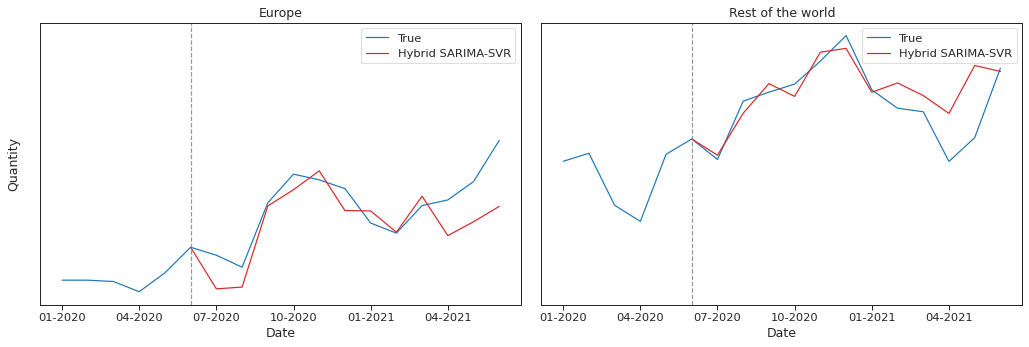

In [13]:
### HYBRID SARIMA-SVR MODEL ###

# CREATE RESIDUAL DATA
data_resid = data.copy()
data_resid = data_resid.merge(df_SARIMA_resid, on=['Date_RAW', 'Mega Market'], how='left')
data_resid.loc[-data_resid.isna().any(axis=1), 'Quantity'] = data_resid[-data_resid.isna().any(axis=1)].iloc[:, -1].values

# INITIALIZE/SELECT MARKET
df = data_resid.copy()
list_markets = ['Europe', 'Rest of the world']

# FUNCTION TO CREATE LAGS USED FOR PERFORMING MODELS
def create_lag(data, lags=[]):
  output = pd.DataFrame({'value': data.values.ravel()})
  for i in lags:
    output['lag_{}'.format(i)] = data.shift(i)
  output = output.dropna()
  return output

# PERFORM FORECASTING ANALYSIS
list_preds_SARIMA_SVR = {}
for market in list_markets:
  random_seed = 1234
  df_market = df[df['Mega Market'] == market]

  Y_scaler = StandardScaler().fit(df_market['Quantity'].to_frame())
  df_market['Quantity'] = Y_scaler.transform(df_market['Quantity'].to_frame()).ravel()

  #############################
  ### FEATURE/LAG SELECTION ###
  #############################

  # ADD LAGGED VARIABLES AS PREDICTORS: PAST 24-MONTHS
  X = df_market[df_market['Date_RAW'] < '2020-07-01']['Quantity'].reset_index(drop=True)
  X = pd.DataFrame(X)
  lag_range = [i+1 for i in range(24)]
  X = create_lag(X.iloc[:, :1], lag_range)

  # SPLIT INTO TRAINING & TEST SET
  X_train = X.iloc[:, 1:]
  y_train = X.iloc[:, :1]

  # FEATURE SELECTION ON LAGGED REGRESSORS USING RF BASED ON PERMUTATION PERFORMANCES
  RF = LGBMRegressor(boosting_type='rf', bagging_freq=1, bagging_fraction=0.8, feature_fraction=0.8, random_state=random_seed).fit(X_train, y_train)
  result = permutation_importance(RF, X_train, y_train, n_repeats=10, random_state=random_seed)

  # USE SELECTED LAGS OBTAINED FROM FEATURE SELECTION
  lags_selected = 1 + np.sort(result.importances_mean.argsort()[::-1][:5])

  ###############################
  ### PERFORM SVR FORECASTING ###
  ###############################

  # SPLIT INTO TRAINING & TEST SET
  X_train = df_market[df_market['Date_RAW'] < '2020-07-01']['Quantity'].reset_index(drop=True)
  X_test = df_market[df_market['Date_RAW'] >= '2020-07-01']['Quantity'].reset_index(drop=True)

  X_train_lagged = create_lag(X_train, lags=lags_selected)
  X_test_lagged = X_train.sort_index(ascending=False).reset_index(drop=True)[[i-1 for i in lags_selected]]
  X_test_lagged = pd.DataFrame(X_test_lagged).T
  X_test_lagged.columns = X_train_lagged.columns[1:]

  # INITIALIZE REGION FOR GRIDSEARCH CV USING TIMESERIES SPLIT
  tcv = TimeSeriesSplit(n_splits=5)
  n_jobs = -1
  C = [0.001, 0.01, 0.1, 1, 10, 50] 
  gamma = [0.0001, 0.001, 0.01, 0.1, 1, 10]

  # SVM USING RBF KERNEL
  np.random.RandomState(random_seed)
  SVR_rbf = SVR(kernel='rbf', cache_size=1500)
  SVR_rbf_optimal = GridSearchCV(estimator=SVR_rbf, param_grid=dict(C=C, gamma=gamma), n_jobs=n_jobs, cv=tcv).fit(X_train_lagged.iloc[:, 1:], X_train_lagged.iloc[:, :1].values.ravel()).best_estimator_
  print(SVR_rbf_optimal)
  # APPLY RECURSIVE MULTI-STEP AHEAD FORWARD PREDICTION
  SVR_preds = []
  for i in range(len(X_test)):
    X_train_lagged = create_lag(X_train, lags=lags_selected)
    X_test_lagged = X_train.sort_index(ascending=False).reset_index(drop=True).loc[[i-1 for i in lags_selected]]
    X_test_lagged = pd.DataFrame(X_test_lagged).T
    X_test_lagged.columns = X_train_lagged.columns[1:]

    SVR_rbf_fit = SVR_rbf_optimal
    SVR_preds.append(SVR_rbf_fit.predict(X_test_lagged)[0])

    X_train = X_train.append(pd.Series(SVR_preds[i]), ignore_index=True)

  # STORE RESULTS RF
  df_results = pd.DataFrame({'SARIMA_SVR_preds': Y_scaler.inverse_transform(pd.DataFrame(SVR_preds)).ravel()})
  list_preds_SARIMA_SVR[market] = df_results

df_SARIMA_SVR = create_df_plot('SVR', list_preds_SARIMA_SVR)
df_SARIMA_SVR = df_SARIMA_SVR.merge(df_SARIMA, on=['Date_RAW', 'Mega Market'], how='left')
df_SARIMA_SVR['Hybrid SARIMA-SVR'] = df_SARIMA_SVR['SVR'] + df_SARIMA_SVR['SARIMA']
df_SARIMA_SVR = df_SARIMA_SVR.drop(columns=['SVR', 'SARIMA'])

print(df_SARIMA_SVR)
create_graph(df_SARIMA_SVR)

# FORECAST KPI

In [14]:
def calculate_RMSE(df_input):
  df_true = data[['Date_RAW', 'Mega Market', 'Quantity']].copy().rename(columns={'Quantity': 'True'})
  df_output=df_input.merge(df_true, on=['Date_RAW','Mega Market'],how='left')
  true = df_output.iloc[:, -1]
  pred = df_output.iloc[:, -2]
  RMSE = np.sqrt(mean_squared_error(true,pred))
  return RMSE

def calculate_MAPE(df_input):
  df_true = data[['Date_RAW','Mega Market','Quantity']].copy().rename(columns={'Quantity': 'True'})
  df_output=df_input.merge(df_true, on=['Date_RAW','Mega Market'],how='left')
  true = df_output.iloc[:, -1]
  pred = df_output.iloc[:, -2]
  MAPE = np.mean(np.abs(true-pred)/true)
  return MAPE

list_models = {'Holt-Winters': df_HW, 'SARIMA': df_SARIMA, 'SVR': df_SVR, 'Hybrid SARIMA-SVR': df_SARIMA_SVR}
df_KPI = pd.DataFrame()
for model in list_models:
  df_KPI = df_KPI.append({'Model': model,
                          'Output RMSE':calculate_RMSE(list_models[model][list_models[model]['Mega Market'] == 'Europe']),
                          'Output MAPE':calculate_MAPE(list_models[model][list_models[model]['Mega Market'] == 'Europe'])}, ignore_index=True)

df_KPI


,Model,Output MAPE,Output RMSE
0,Holt-Winters,0.300248,33322.481239
1,SARIMA,0.101616,13804.738130
2,SVR,0.481661,47990.055472
3,Hybrid SARIMA-SVR,0.165100,18554.970011


In [15]:
#Final results
df_test = data[(data['Date_RAW'] >= '2020-07-01') & (data['Date_RAW'] < '2021-12-01')][['Mega Market', 'Date_RAW', 'Quantity']].rename(columns={'Quantity': 'Actual data'}).reset_index(drop=True)
df_model = pd.concat([df_test,df_HW,df_SARIMA,df_SVR,df_SARIMA_SVR],axis=1,  ignore_index=False)
df_date = df_test.drop("Actual data",axis=1)
outcome = df_model.drop(["Date_RAW","Mega Market"], axis=1)
outcome = df_date.join(outcome)
outcome


,Mega Market,Date_RAW,Actual data,Holt-Winters,SARIMA,SVR,Hybrid SARIMA-SVR
0,Europe,2020-07-01,56065.0,39293.737678,56531.988277,28156.000014,34236.065516
1,Europe,2020-08-01,48284.0,35812.635524,56448.002007,22269.995541,35385.009148
2,Europe,2020-09-01,90023.0,67749.252809,70900.729974,43490.564194,87979.533857
3,Europe,2020-10-01,108622.0,119487.964405,102706.363964,78888.604705,98536.123662
4,Europe,2020-11-01,104936.0,115240.216485,110643.475047,83314.078285,110775.130345
5,Europe,2020-12-01,99233.0,90433.354911,101006.984914,53923.076549,85015.045890
6,Europe,2021-01-01,76908.0,52651.982803,78877.296363,37553.433488,84788.436928
7,Europe,2021-02-01,70371.0,49863.972862,78345.429600,42099.175258,70956.417916
8,Europe,2021-03-01,88255.0,55248.586115,85711.062249,50026.537295,94316.378216
9,Europe,2021-04-01,91890.0,48780.606329,84707.866582,44181.464845,68749.307171


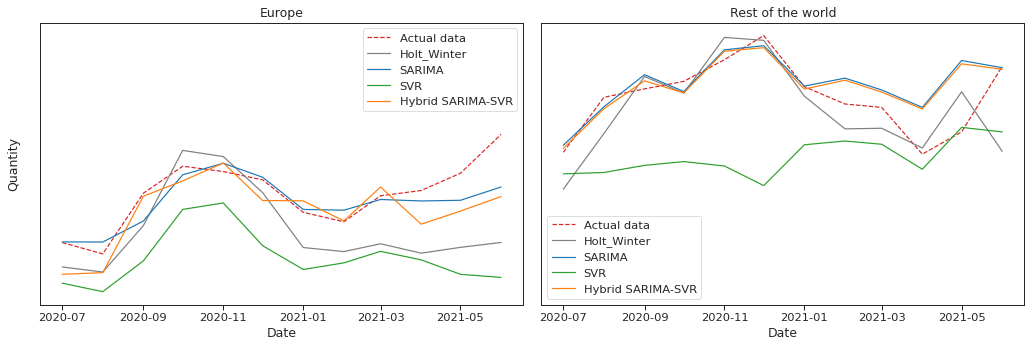

In [16]:
with sns.plotting_context('paper', font_scale=1.3):
    g = sns.FacetGrid(outcome, col='Mega Market', col_wrap=2, size=5, aspect=1.5, despine=False)
    g = g.map(sns.lineplot, 'Date_RAW', 'Actual data', color='tab:red', label='Actual data', linestyle='--')
    g = g.map(sns.lineplot, 'Date_RAW', 'Holt-Winters', color='tab:grey', label='Holt_Winter')
    g = g.map(sns.lineplot, 'Date_RAW', 'SARIMA', color='tab:blue', label='SARIMA')
    g = g.map(sns.lineplot, 'Date_RAW', 'SVR', color='tab:green', label='SVR')
    g = g.map(sns.lineplot, 'Date_RAW', 'Hybrid SARIMA-SVR', color='tab:orange', label='Hybrid SARIMA-SVR')

    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    g.set(yticks=[], xlabel='Date', ylabel='Quantity')
    for ax in g.axes:
      ax.yaxis.labelpad=20
    for ax in g.axes.ravel():
      ax.legend()

In [ ]:
fig = plt.figure()
fig.suptitle('Retail Sales of Air Fryers')
actual, = plt.plot(outcome['Date_RAW'], df_test.iloc[:,2:3], 'r.-', label='Actual Sales')
Holt_Winter, = plt.plot(outcome['Date_RAW'], df_HW.iloc[:,2:3], 'b.-',label='Holt_Winter')
SARIMA, = plt.plot(outcome['Date_RAW'], df_SARIMA.iloc[:,2:3], 'g.-', label='SARIMA')
plt.legend(handles=[actual, Holt_Winter, SARIMA])
plt.show()